# <b>МОДЕЛЬ 1</b> | `Include_top`

## Модуль `tf.keras.applications` | `feature_extractor_layer`

Создадим `feature_extractor`, который извлечет веса из предобученной модели `tensorflow` для переноса обучения на нашу модель. При переносе обучения рекомендуется отключать самые "верхние", то есть последние слои предобученной модели: именно в них происходит обучение на данную классификацию. Однако для начала мы проверим, как будут обучаться наши модели на полной предобученной модели `Mobile Net V2`.

Во втором блоке экспериментов мы отключим верхние слои, а в третьем пойдем еще дальше и разморозим часть слоев предобученной модели. За "разморозку" слоев у нас будет отвечать параметр `do_fine_tuning`, который может принимать только булевы значения (в первых двух блоках он установлен в режим `False`).

Итак, приступим к первому блоку экспериментов, используем предобученную модель "как есть". 

In [205]:
do_fine_tuning = False
feature_extractor = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')
feature_extractor.trainable = do_fine_tuning

print(f'Разморозка слоев: {do_fine_tuning}.')

Разморозка слоев: False.


## <b>Модель 1.1</b> | Baseline

Построим базовую последовательную модель, в которой у нас будут только слои `rescale`,  `feature_extractor` и слой предсказания.

### Архитектура модели

In [217]:
print(f'Строим модель на базе {MODULE_HANDLE}.')
print(f'Разморозка слоев: {do_fine_tuning}.\n')

model = tf.keras.Sequential([
            rescale,
            data_aug,
            feature_extractor,
            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(num_classes, activation='softmax')
], name='model_11')

model.summary()

Строим модель на базе tf.keras.applications.MobileNetV2.
Разморозка слоев: False.

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1000)             3538984   
 ional)                                                          
                                                                 
 dropout_22 (Dropout)        (None, 1000)              0         
                                                                 
 batch_normalization_34 (Bat  (None, 1000)             4000      
 chNormalization)                                                
                                                                 
 dense_42 (Dense)            (None, 64)                64064     
                                         

Проверим количество обучаемых параметров. Два означает - вектор значений весов (kernel) и вектор значений свободных членов (bias).

In [218]:
len(model.trainable_variables)

8

### Компиляция

В качестве оптимизатора во всех моделях неизменно будем использовать Adam, learning_rate установим базовый, он будет корректироваться как самим оптимизатором внутри эпохи, так и в начале каждой эпохи благодаря `lr_schedule` `callback`.

In [219]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=BASE_LR),
              loss='categorical_crossentropy',
              metrics=metrics)

Модель скомпилирована, то есть все заданные параметры зафиксированы до следующей компиляции.

### Обучение модели

На стадии обучения модели зададим зафиксированное количество эпох (500), которое в процессе обучения будет автоматически оптимизировано соответствующим callback'ом. 

In [220]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule]
                )

Epoch 1/500
34/34 [==============================] - 57s 2s/step - loss: 1.8470 - accuracy: 0.2685 - PR_AUC: 0.2504 - val_loss: 1.5977 - val_accuracy: 0.2642 - val_PR_AUC: 0.2392 - lr: 0.0100
Epoch 2/500
34/34 [==============================] - 60s 2s/step - loss: 1.5336 - accuracy: 0.3593 - PR_AUC: 0.3581 - val_loss: 1.5869 - val_accuracy: 0.2453 - val_PR_AUC: 0.2615 - lr: 0.0100
Epoch 3/500
34/34 [==============================] - 50s 1s/step - loss: 1.3947 - accuracy: 0.4250 - PR_AUC: 0.4278 - val_loss: 1.5794 - val_accuracy: 0.2767 - val_PR_AUC: 0.2878 - lr: 0.0100
Epoch 4/500
34/34 [==============================] - 59s 2s/step - loss: 1.3417 - accuracy: 0.4417 - PR_AUC: 0.4667 - val_loss: 1.5709 - val_accuracy: 0.2642 - val_PR_AUC: 0.2875 - lr: 0.0100
Epoch 5/500
34/34 [==============================] - 52s 2s/step - loss: 1.2809 - accuracy: 0.4657 - PR_AUC: 0.5037 - val_loss: 1.5619 - val_accuracy: 0.3019 - val_PR_AUC: 0.2983 - lr: 0.0100
Epoch 6/500
34/34 [=====================

KeyboardInterrupt: 

### Визуализация данных по работе алгоритма

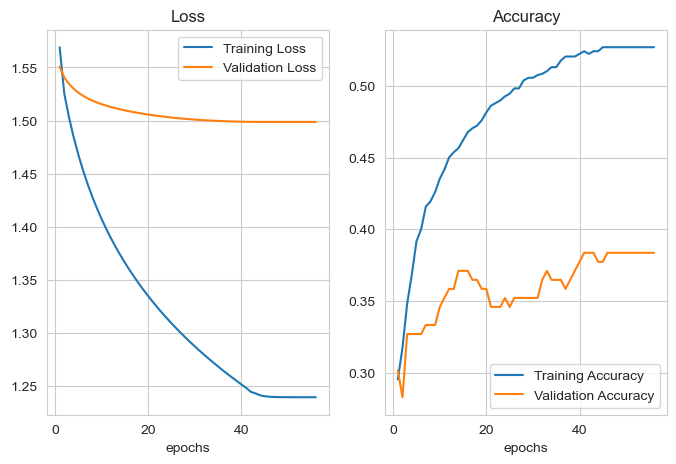

In [313]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

#### На изображениях из Сети

При желании качество работы модели можно проверить на реальных фотографиях экспертным методом. Для этого создадим новую папку, куда загрузим желаемые изображения. Далее, подготовленная функция преобразует изображения в необходимый для визуализации и предсказания формат. Оставим эту часть в качестве дополнения, использовать ее пока не будем.

In [ ]:
# from PIL import Image
# import numpy as np
# from tensorflow.keras.utils import load_img, img_to_array
# import os

# new_test_dir = Path('./data/test_images')
# Path.mkdir(new_test_dir)

# def show_predictions(model):
    
#     images = os.listdir(new_test_dir)
    
#     for i, img_path in enumerate(images):

#         # путь к тестовым изображениям
#         path = new_test_dir / img_path

#         # приведение изображений к желаемому разрешению
#         img = load_img(path, target_size=IMAGE_SIZE + (3,))
#         # перевод изображения в массив
#         x = img_to_array(img)

#         # добавление четвертого измерения для модели
#         images = np.expand_dims(x, axis=0)
        
#         plt.figure(figsize=(2, 2))
#         # Отключить оси
#         plt.axis(False)
#         plt.imshow(np.squeeze(images).astype('uint8'))
#         # plt.title(img_path)
#         plt.show()

#         # предсказание
#         classes = model.predict(images, batch_size=10)

#         class_pred = np.argmax(classes)
#         # print(np.argmax(class_pred))
#         print(f'{img_path} is {class_names[class_pred]} ({np.max(classes[0])*100:.2f}%)')
        
# show_predictions(model)

#### На изображениях из тестовой выборки

Посмотрим на то, как модель предсказывает тестовые изображения, хранящиеся в третьей, тестовой выборке, которая до этого момента не принимала участия в работе. Напомним, что тестовая выбора разбита на батчи по одному изображению, что позволяет нам проще контролировать количество изображений, которое мы хотим использовать для предсказания. Следующая функция покажет изображение, заданное и предсказанное значение класса, а также "уверенность" модели в своем предсказании. На данном этапе посмотрим на небольшое количество изображений (по умолчанию 10, можно изменить это число, задав соответствующий аргумент), а полную картину оценим дальше, построив матрицу ошибок.

In [ ]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
import os

def show_predictions(model, image_set=test_batches,
                     images_number=10, visualization=False):

    images = image_set.take(images_number)

    for img, label in images:

        if visualization == True:
            plt.figure(figsize=(2, 2))
            # Отключить оси
            plt.axis(False)
            # оставим три измерения из четырех
            image = np.squeeze(img)
            plt.imshow(image.astype('uint8'))
            plt.show()

        # реальный класс
        label = np.argmax(label)
        # предсказанный класс
        prediction = model.predict(img)
        pred = np.argmax(prediction)

        print(f'{class_names[label]} is {class_names[pred]} ({np.max(prediction[0])*100:.2f}%)')

In [314]:
show_predictions(model, visualization=False)

neutral is disgust (30.62%)
neutral is neutral (70.08%)
neutral is neutral (93.90%)
fear is fear (56.81%)
joyfulness is joyfulness (35.87%)
joyfulness is joyfulness (29.68%)
anger is joyfulness (34.31%)
disgust is anger (24.19%)
neutral is neutral (57.09%)
fear is neutral (32.72%)


### Матрица ошибок

Напишем функцию для отображения матрицы ошибок, которая пригодится нам и в дальнейшем.

In [ ]:
def confusion_matrix(model, images_number=None, dataset=test_batches, class_names=class_names):

    '''
    Выводит матрицу ошибок на тестовых данных. 
    
    Аргументы:
    - model - обученная модель.
    - images_number - количество изображений из тестовой выборки;
            если None, то используются все изображения в выборке.
    - dataset - tf.dataset с тестовыми изображениями.
    '''
    
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    if images_number is None:
        test_images = dataset
    else:
        test_images = dataset.take(images_number)
        
    y_test, y_pred = ([np.argmax(y) for _, y in test_images], 
                      [np.argmax(x) for x in model.predict(test_images)])
        
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot()
    plt.show()

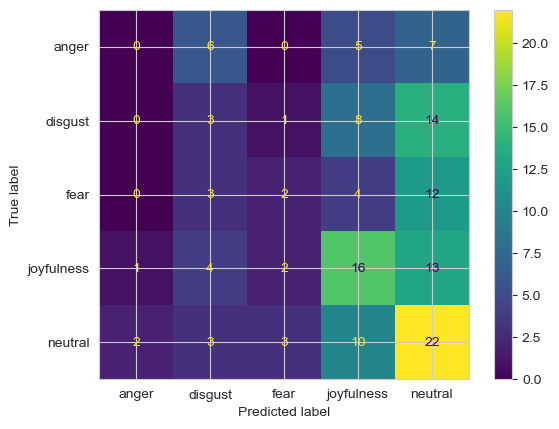

In [315]:
confusion_matrix(model)

### Вывод

Модель удивительно устойчива к переобучению без каких-либо дополнительных слоев, но при этом и к обучению она практически неспособна. Матрица ошибок показывает, что данная модель с трудом обучается отдельным классам.

Зафиксируем ее лучший показатель `val_accuracy` и попробуем улучшить модель.

In [316]:
val_acc_best = np.max(hist.history['val_accuracy'])
baseline_best_result = round(val_acc_best, 2)
baseline_best_result

0.38

In [317]:
# сохраним данные о модели
model_1_1 = model
hist_1_1 = hist

## <b>Модель 1.2</b> | Deeper baseline

Так как базовая модель очень устойчива к переобучению, но при этом обучается крайне медленно, есть смысл попробовать углубить модель (добавить полносвязных слоев) и расширить ее (увеличить количество обучаемых параметров в полносвязных слоях).

### Архитектура модели

In [ ]:
print(f'Строим модель на базе {MODULE_HANDLE}.')
print(f'Разморозка слоев: {do_fine_tuning}.\n')

model = tf.keras.Sequential([

            rescale,

            feature_extractor,

            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(1024, activation='relu'),
            tf.keras.layers.Dense(1024, activation='relu'),
            tf.keras.layers.Dense(num_classes, activation='softmax')

], name='deeper_baseline')

model.build(input_shape=(None,) + IMAGE_SIZE + (3,))
model.summary()

In [ ]:
len(model.trainable_variables)

### Компиляция

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=BASE_LR),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

### Обучение модели

In [ ]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule]
                )

### Визуализация данных по работе алгоритма

In [ ]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

In [ ]:
show_predictions(model)

### Матрица ошибок

In [ ]:
confusion_matrix(model)

### Вывод

Модель очень быстро переобучилась, практически с первых эпох, при этом показатели удалось несколько улучшить. Анализ матрицы ошибок показывает, что лучше всего модель предсказывает класс `neutral`, что неудивительно, так как именно в данном классе у нас больше всего изображений. 

Зафиксируем лучший показатель `val_accuracy` и сохраним данные по результатам работы модели в отдельные переменные на случай, если потребуется к ним снова обратиться.

In [ ]:
val_acc_best = np.max(hist.history['val_accuracy'])
model_1_2_best_result = round(val_acc_best, 2)
model_1_2_best_result

In [ ]:
# сохраним данные о модели
model_1_2 = model
hist_1_2 = hist

## <b>Модель 1.3</b> | Dropout и BatchNormalization layers

Доработаем предыдущую модель, добавив в ее архитектуру аугментацию данных и слои батч-нормализации и `dropout`. Это позволит нам отложить момент переобучения.

### Архитектура модели

In [ ]:
print(f'Строим модель на базе {MODULE_HANDLE}.')
print(f'Разморозка слоев: {do_fine_tuning}.\n')

model = tf.keras.Sequential([

            rescale,
            data_aug,

            feature_extractor,

            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(512, activation='relu'),

            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(1024, activation='relu'),

            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(1024, activation='relu'),

            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(num_classes, activation='softmax')

], name='deeper_DropOut_BN_baseline')

model.build(input_shape=(None,) + IMAGE_SIZE + (3,))
model.summary()

In [ ]:
len(model.trainable_variables)

### Компиляция

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=BASE_LR),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

### Обучение модели

In [ ]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule]
                )

### Визуализация данных по работе алгоритма

In [ ]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

In [ ]:
show_predictions(model)

### Матрица ошибок

In [ ]:
confusion_matrix(model)

### Вывод

Модель очень быстро переобучилась, практически с первых эпох, при этом и ее предсказательная способность значительно выросла. Анализ матрицы ошибок показывает, что лучше всего модель предсказывает класс `neutral`, что неудивительно, так как именно в данном классе у нас больше всего изображений. Зафиксируем лучший показатель `val_accuracy` и сохраним данные по результатам работы модели в отдельные переменные на случай, если потребуется к ним снова обратиться.

In [ ]:
val_acc_best = np.max(hist.history['val_accuracy'])
model_1_3_best_result = round(val_acc_best, 2)
model_1_3_best_result

In [ ]:
# сохраним данные о модели
model_1_3 = model
hist_1_3 = hist

# <b>МОДЕЛЬ 2</b> | Bottleneck

## Модуль `tf.keras.applications` | `feature_extractor_layer`

Во втором блоке экспериментов будем работать с предобученной моделью, у которой отключены самые верхние слои на классификацию, цель: дообучить собственный классификатор. 

Выбрав опцию `include_top=False` мы оставляем для нашей модели все слои до самого последнего перед слоем `Flatten` предобученной модели (в литературе его называют слоем "бутылочным горлышком" - "bottleneck layer"), туда мы поместим наши собственные полносвязные слои, которые в предыдущем блоки шли за полной предуобченной моделью. Признаки, содержащиеся в "бутылочном горлышке", представляют наибольшую ценность, так как именно они содержат самые  общие признаки изображений (в отличие от более специфичных признаков для конкретных классов в верхних слоях).

In [336]:
do_fine_tuning = False
feature_extractor_bottleneck = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
feature_extractor_bottleneck.trainable = do_fine_tuning

## <b>Модель 2.1</b> | Bottleneck baseline

### Архитектура модели

Добавим слой `Flatten`, который мы исключаем из предобученной модели, чтобы перевести матрицы изображений в векторный вид (либо можно активировать аттрибут `pooling` внутри самого `feature_extractor`), другие слои пока добавлять не будем.

In [238]:
print(f'Строим модель на базе {MODULE_HANDLE}.')
print(f'Разморозка слоев: {do_fine_tuning}.\n')

strides = 2

model = tf.keras.Sequential([

            rescale,
            data_aug,

            feature_extractor_bottleneck,

            tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=2, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=strides, activation='relu'),

            tf.keras.layers.Flatten(),

            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(64, activation='relu',
                                  kernel_regularizer=REGULARIZER,
                                  bias_regularizer=REGULARIZER),

            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(num_classes, activation='softmax',
                                  kernel_regularizer=REGULARIZER,
                                  bias_regularizer=REGULARIZER)

], name='bottleneck_baseline')

model.summary()

Строим модель на базе tf.keras.applications.MobileNetV2.
Разморозка слоев: False.

Model: "bottleneck_baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_95 (Conv2D)          (None, 4, 4, 32)          368672    
                                                                 
 max_pooling2d_71 (MaxPoolin  (None, 2, 2, 32)         0         
 g2D)                                                            
                              

In [239]:
len(model.trainable_variables)

12

### Компиляция

In [240]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=BASE_LR),
              loss='categorical_crossentropy',
              metrics=metrics)

### Обучение модели

In [241]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule])

Epoch 1/500
34/34 [==============================] - 76s 2s/step - loss: 7.4646 - accuracy: 0.2741 - PR_AUC: 0.2606 - val_loss: 7.1673 - val_accuracy: 0.2956 - val_PR_AUC: 0.3058 - lr: 0.0100
Epoch 2/500
34/34 [==============================] - 74s 2s/step - loss: 6.8861 - accuracy: 0.3352 - PR_AUC: 0.3418 - val_loss: 6.8597 - val_accuracy: 0.3019 - val_PR_AUC: 0.3263 - lr: 0.0100
Epoch 3/500
34/34 [==============================] - 58s 2s/step - loss: 6.5697 - accuracy: 0.3824 - PR_AUC: 0.3715 - val_loss: 6.4049 - val_accuracy: 0.3711 - val_PR_AUC: 0.3284 - lr: 0.0100
Epoch 4/500
34/34 [==============================] - 60s 2s/step - loss: 6.1660 - accuracy: 0.4463 - PR_AUC: 0.4704 - val_loss: 6.1635 - val_accuracy: 0.4151 - val_PR_AUC: 0.4091 - lr: 0.0100
Epoch 5/500
34/34 [==============================] - 57s 2s/step - loss: 5.9048 - accuracy: 0.4833 - PR_AUC: 0.5098 - val_loss: 5.9729 - val_accuracy: 0.3962 - val_PR_AUC: 0.3864 - lr: 0.0100
Epoch 6/500
34/34 [=====================

### Визуализация данных по работе алгоритма

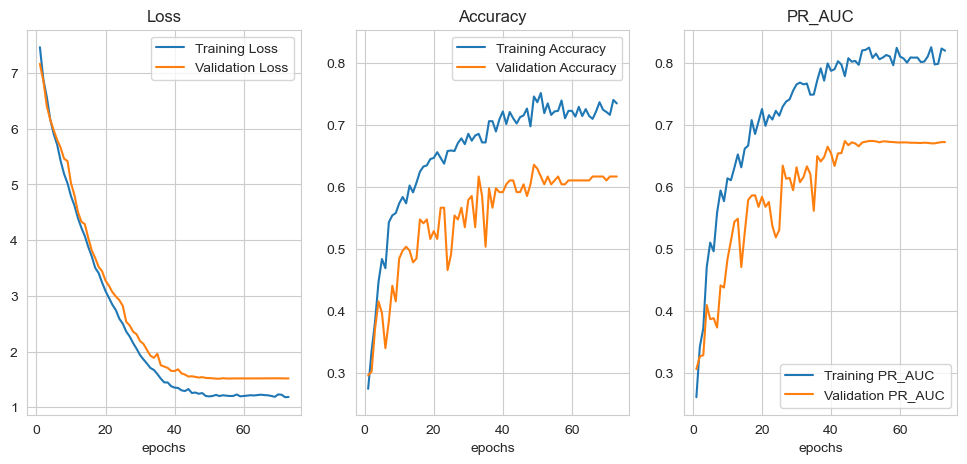

In [242]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

In [223]:
show_predictions(model)

joyfulness is joyfulness (57.78%)
neutral is neutral (51.43%)
anger is joyfulness (25.68%)
neutral is neutral (51.19%)
neutral is neutral (51.59%)
fear is neutral (52.27%)
neutral is neutral (51.88%)
anger is disgust (23.27%)
neutral is neutral (50.40%)
disgust is neutral (52.23%)


### Матрица ошибок

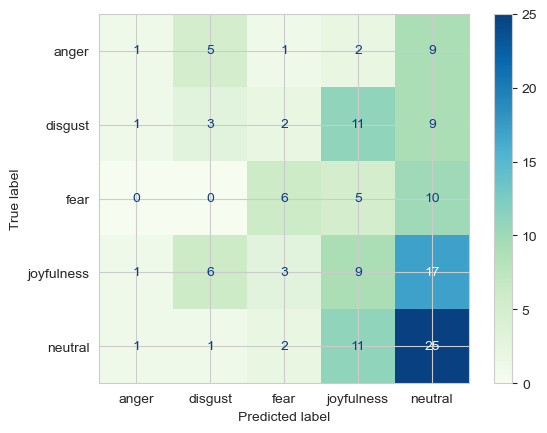

In [245]:
confusion_matrix(model)

### Вывод

Модель очень быстро переобучилась, практически с первых эпох, при этом и ее предсказательная способность значительно выросла. Анализ матрицы ошибок показывает, что лучше всего модель предсказывает класс `neutral`, что неудивительно, так как именно в данном классе у нас больше всего изображений. Зафиксируем лучший показатель `val_accuracy` и сохраним данные по результатам работы модели в отдельные переменные на случай, если потребуется к ним снова обратиться.

In [249]:
val_acc_best = np.max(hist.history['val_accuracy'])
val_auc_best = np.max(hist.history['val_PR_AUC'])
model_21_best_result = round(val_acc_best, 2), round(val_auc_best, 2)

print(f'val_accuracy: {model_21_best_result[0]}')
print(f'val_PR_AUC: {model_21_best_result[1]}')

val_accuracy: 0.64
val_PR_AUC: 0.67


In [250]:
# сохраним данные о модели
model_21 = model
hist_21 = hist

## <b>Модель 2.2</b> | Bottleneck baseline cont

### Архитектура модели

Добавим слой `Flatten`, который мы исключаем из предобученной модели, чтобы перевести матрицы изображений в векторный вид (либо можно активировать аттрибут `pooling` внутри самого `feature_extractor`), другие слои пока добавлять не будем.

In [338]:
print(f'Строим модель на базе {MODULE_HANDLE}.')
print(f'Разморозка слоев: {do_fine_tuning}.\n')

strides = 1

model = tf.keras.Sequential([

            rescale,
            data_aug,

            feature_extractor_bottleneck,

            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=2, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=strides, activation='relu'),

            tf.keras.layers.Flatten(),

            # tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(64, activation='relu',
                                  kernel_regularizer=REGULARIZER,
                                  # bias_regularizer=REGULARIZER
                                 ),

            # tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(64, activation='relu',
                                  kernel_regularizer=REGULARIZER,
                                  # bias_regularizer=REGULARIZER
                                 ),

            # tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(64, activation='relu',
                                  kernel_regularizer=REGULARIZER,
                                  # bias_regularizer=REGULARIZER
                                 ),

            tf.keras.layers.Dropout(DROPOUT_RATE),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(num_classes, activation='softmax',
                                  kernel_regularizer=REGULARIZER,
                                  # bias_regularizer=REGULARIZER
                                 )

], name='bottleneck_baseline_cont')

model.summary()

Строим модель на базе tf.keras.applications.MobileNetV2.
Разморозка слоев: False.

Model: "bottleneck_baseline_cont"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_136 (Conv2D)         (None, 4, 4, 32)          368672    
                                                                 
 max_pooling2d_91 (MaxPoolin  (None, 2, 2, 32)         0         
 g2D)                                                            
                         

In [339]:
len(model.trainable_variables)

20

### Компиляция

In [340]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=BASE_LR),
              loss='categorical_crossentropy',
              metrics=metrics)

### Обучение модели

In [341]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule])

Epoch 1/500
34/34 [==============================] - 71s 2s/step - loss: 24.5112 - accuracy: 0.2333 - PR_AUC: 0.2259 - val_loss: 24.0953 - val_accuracy: 0.2642 - val_PR_AUC: 0.2258 - lr: 0.0100
Epoch 2/500
34/34 [==============================] - 72s 2s/step - loss: 23.1053 - accuracy: 0.3306 - PR_AUC: 0.2992 - val_loss: 23.0195 - val_accuracy: 0.3333 - val_PR_AUC: 0.2883 - lr: 0.0100
Epoch 3/500
34/34 [==============================] - 65s 2s/step - loss: 21.8812 - accuracy: 0.3602 - PR_AUC: 0.3500 - val_loss: 21.3945 - val_accuracy: 0.3019 - val_PR_AUC: 0.2826 - lr: 0.0100
Epoch 4/500
34/34 [==============================] - 72s 2s/step - loss: 20.7400 - accuracy: 0.4009 - PR_AUC: 0.3878 - val_loss: 20.1726 - val_accuracy: 0.4340 - val_PR_AUC: 0.3979 - lr: 0.0100
Epoch 5/500
34/34 [==============================] - 76s 2s/step - loss: 19.6573 - accuracy: 0.4269 - PR_AUC: 0.4230 - val_loss: 19.2019 - val_accuracy: 0.3648 - val_PR_AUC: 0.3995 - lr: 0.0100
Epoch 6/500
34/34 [===========

KeyboardInterrupt: 

### Визуализация данных по работе алгоритма

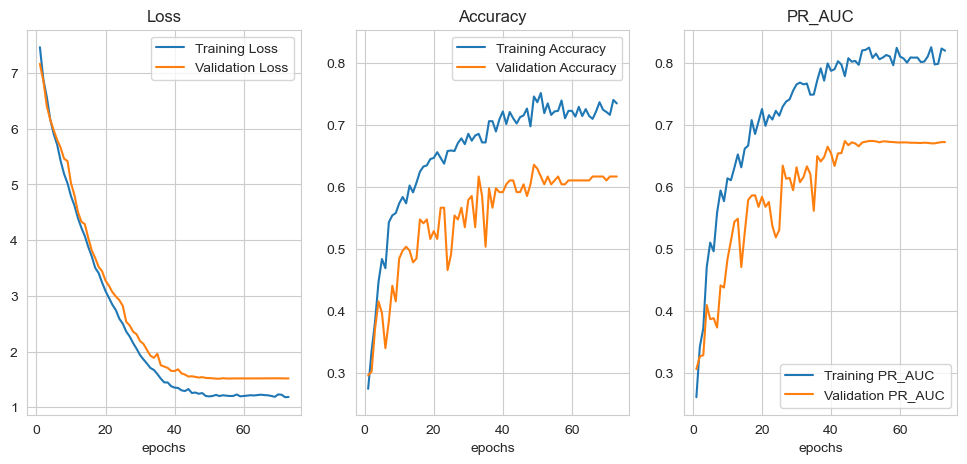

In [242]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

In [223]:
show_predictions(model)

joyfulness is joyfulness (57.78%)
neutral is neutral (51.43%)
anger is joyfulness (25.68%)
neutral is neutral (51.19%)
neutral is neutral (51.59%)
fear is neutral (52.27%)
neutral is neutral (51.88%)
anger is disgust (23.27%)
neutral is neutral (50.40%)
disgust is neutral (52.23%)


### Матрица ошибок

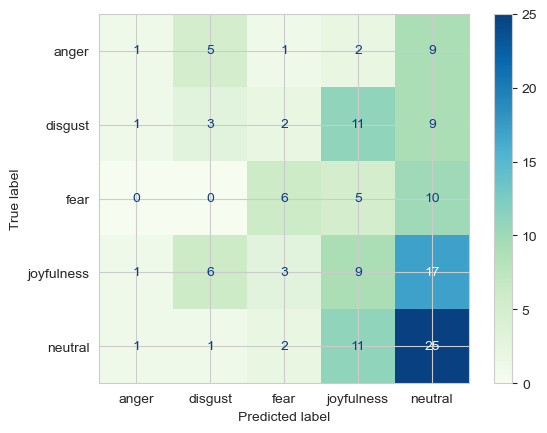

In [245]:
confusion_matrix(model)

### Вывод

Модель очень быстро переобучилась, практически с первых эпох, при этом и ее предсказательная способность значительно выросла. Анализ матрицы ошибок показывает, что лучше всего модель предсказывает класс `neutral`, что неудивительно, так как именно в данном классе у нас больше всего изображений. Зафиксируем лучший показатель `val_accuracy` и сохраним данные по результатам работы модели в отдельные переменные на случай, если потребуется к ним снова обратиться.

In [249]:
val_acc_best = np.max(hist.history['val_accuracy'])
val_auc_best = np.max(hist.history['val_PR_AUC'])
model_21_best_result = round(val_acc_best, 2), round(val_auc_best, 2)

print(f'val_accuracy: {model_21_best_result[0]}')
print(f'val_PR_AUC: {model_21_best_result[1]}')

val_accuracy: 0.64
val_PR_AUC: 0.67


In [250]:
# сохраним данные о модели
model_21 = model
hist_21 = hist

## <b>Модель 2.2</b> | `fine_tuning`

На следующем шаге проверим эту же модель, но разморозим часть слоев предобученной модели. В официальных документах указано, что размораживать слои следует только после того, как мы уже обучили собственный классификатор, в ином случае предобученная модель с установленными в случайном порядке весами для новых слоев при обновлении весов потеряет все, чему она была обучена.

Кроме того, нет необходимости в разморозке "нижних слоев", так как они обнаруживают самые простые и общие закономерности, характерные для любых изображений. Цель применения предобученной модели - использовать более "специализированные" слои для дообучения новой модели на новом датасете, поэтому возьмем сравнительно небольшое число "верхних" слоев.

Особого внимания в случае разморозки `feature_extractor` заслуживают слои bacth normalization (`BN`). Это единственные встроенные слои, веса которых не должны обновляться при градиентном спуске, так как эти веса - движущиеся среднее значение и стандартное отклонение для нормализации текущего батча. Запустив модель в режиме `trainable=False`, мы эти слои заморозили. Когда мы на следующем шаге размораживаем всю модель или ее часть, слои BN продолжают работать в режиме inference (движущиеся mean и std), а не обучения (mean и std текущего батча). Это очень важный момент, так как если мы запустим `feature_extractor` сразу в режиме разморозки без предварительного обучения на замороженных слоях (то есть не заморозим веса BN), слои BN будут давать непредсказуемый результат (подробнее о проблеме [здесь](https://keras.io/getting_started/faq/#whats-the-difference-between-the-training-argument-in-call-and-the-trainable-attribute)).

## Модуль `tf.keras.applications` | `feature_extractor_layer`

In [327]:
do_fine_tuning = True
feature_extractor_bottleneck = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
feature_extractor_bottleneck.trainable = do_fine_tuning

print(f'Разморозка слоев: {do_fine_tuning}.')

Разморозка слоев: True.


Посмотрим на количество слоев в предобученной модели:

In [328]:
print("Number of layers in the feature extractor: ", len(feature_extractor_bottleneck.layers))

Number of layers in the feature extractor:  154


In [329]:
# с какого слоя мы размораживаем модель
fine_tune_at = 100

# Заморозим все остальные слои
for layer in feature_extractor_bottleneck.layers[:fine_tune_at]:
    layer.trainable = False

print("Trainable layers in the feature extractor: ", len(feature_extractor_bottleneck.trainable_variables))

Trainable layers in the feature extractor:  54


In [330]:
print(f'Строим модель на базе {MODULE_HANDLE}.')
print(f'Разморозка слоев: {do_fine_tuning}.\n')

strides = 1

model = tf.keras.Sequential([

            rescale,
            # data_aug,

            feature_extractor_bottleneck,

            tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=2, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=strides, activation='relu'),

            tf.keras.layers.Flatten(),

            tf.keras.layers.Dropout(DROPOUT_RATE*2),
            # tf.keras.layers.BatchNormalization(),
            # tf.keras.layers.Dense(64, activation='relu',
            #                       kernel_regularizer=REGULARIZER,
            #                       bias_regularizer=REGULARIZER),

            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(num_classes, activation='softmax',
                                  kernel_regularizer=REGULARIZER,
                                  # bias_regularizer=REGULARIZER
                                 )

], name='bottleneck_baseline_cont')

model.summary()

Строим модель на базе tf.keras.applications.MobileNetV2.
Разморозка слоев: True.

Model: "bottleneck_baseline_cont"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_134 (Conv2D)         (None, 4, 4, 32)          368672    
                                                                 
 max_pooling2d_90 (MaxPoolin  (None, 2, 2, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_135 (Conv2D)         (None, 2, 2, 64)          18496     
                          

## Компиляция

Теперь необходимо скомпилировать нашу уже обученную на предыдущем этапе модель, чтобы изменения были применены.

In [331]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=BASE_LR),
              loss='categorical_crossentropy',
              metrics=metrics)

## Архитектура модели

In [332]:
model.summary()

Model: "bottleneck_baseline_cont"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_134 (Conv2D)         (None, 4, 4, 32)          368672    
                                                                 
 max_pooling2d_90 (MaxPoolin  (None, 2, 2, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_135 (Conv2D)         (None, 2, 2, 64)          18496     
                                                                 
 flatten_51 (Flatten)        (None, 256)  

In [333]:
len(model.trainable_variables)

62

## Обучение модели

In [334]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule])

Epoch 1/500
34/34 [==============================] - 102s 3s/step - loss: 21.6522 - accuracy: 0.2759 - PR_AUC: 0.2661 - val_loss: 8.2551 - val_accuracy: 0.3145 - val_PR_AUC: 0.2779 - lr: 0.0100
Epoch 2/500
34/34 [==============================] - 76s 2s/step - loss: 8.1061 - accuracy: 0.3556 - PR_AUC: 0.3587 - val_loss: 8.2091 - val_accuracy: 0.2704 - val_PR_AUC: 0.2421 - lr: 0.0100
Epoch 3/500
34/34 [==============================] - 96s 3s/step - loss: 8.0931 - accuracy: 0.4259 - PR_AUC: 0.4157 - val_loss: 8.1059 - val_accuracy: 0.3333 - val_PR_AUC: 0.2760 - lr: 0.0100


KeyboardInterrupt: 

# <b>МОДЕЛЬ 3</b> | `fine_tuning`

# <b>Модель 3.1</b> | Pretrained baseline

## Модуль `tf.keras.applications` | `feature_extractor_layer`

Попробуем предолеть проблему переобучения, добавив к предыдущей архитектуре слои с аугментацией данных, которые мы подготовили заранее. Другие параметры оставим нетронутыми. Обратим внимание, что мы создаем новую модель, а не дообучаем предыдущую (дообучением мы займемся позже).

In [659]:
do_fine_tuning = False
feature_extractor = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
feature_extractor.trainable = do_fine_tuning

In [697]:
do_fine_tuning = False
feature_extractor = tf.keras.applications.MobileNet(
                                                input_shape=IMG_SHAPE,
                                                # alpha=1.0,
                                                # depth_multiplier=1,
                                                dropout=DROPOUT_RATE,
                                                include_top=False,
                                                weights="imagenet",
                                                # input_tensor=None,
                                                # pooling=None,
                                                # classes=1000,
                                                classifier_activation='softmax',
                                                # **kwargs
)
feature_extractor.trainable = do_fine_tuning

In [687]:
do_fine_tuning = False
feature_extractor = tf.keras.applications.InceptionV3(
                                                include_top=False,
                                                weights="imagenet",
                                                # input_tensor=None,
                                                input_shape=IMG_SHAPE,
                                                # pooling=None,
                                                # classes=1000,
                                                # classifier_activation="softmax",
)
feature_extractor.trainable = do_fine_tuning

In [739]:
do_fine_tuning = False
feature_extractor = tf.keras.applications.InceptionResNetV2(
                                                include_top=False,
                                                weights="imagenet",
                                                # input_tensor=None,
                                                input_shape=IMG_SHAPE,
                                                # pooling=None,
                                                # classes=1000,
                                                # classifier_activation="softmax",
                                                # **kwargs
)
feature_extractor.trainable = do_fine_tuning

In [688]:
# feature_extractor.summary()

## Архитектура модели

In [740]:
image_batch, label_batch = next(iter(train_batches))
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1536)


In [741]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1536)


In [742]:
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax',
                                  kernel_regularizer=REGULARIZER
                                 )
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


In [743]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = rescale(inputs)
x = data_aug(x)
x = feature_extractor(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(DROPOUT_RATE)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_8   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_112 (Dropout)       (None, 1536)              0   

In [682]:
# print(f'Строим модель на базе {MODULE_HANDLE}.')
# print(f'Разморозка слоев: {do_fine_tuning}.\n')

# strides = 1
# REGULARIZER=tf.keras.regularizers.L1L2(l1=0.0, l2=0.5)

# model = tf.keras.Sequential([

#             rescale,
#             data_aug,

#             feature_extractor,

#             # tf.keras.layers.Conv2D(32, (3, 3), padding="same",
#             #                    strides=strides, activation='relu'),
#             # tf.keras.layers.MaxPooling2D((2, 2)),
#             # tf.keras.layers.Conv2D(64, (3, 3), padding="same",
#             #                    strides=strides, activation='relu'),

#             tf.keras.layers.Flatten(),
#             tf.keras.layers.Dropout(DROPOUT_RATE),
#             tf.keras.layers.BatchNormalization(),
#             tf.keras.layers.Dense(num_classes, activation='softmax',
#                                   kernel_regularizer=REGULARIZER
#                                  )

# ], name='pretrained_baseline')

# model.summary()

In [711]:
len(model.trainable_variables)

2

## Компиляция

In [744]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=BASE_LR),
              loss='mse',
              metrics=metrics)

## Обучение модели

In [745]:
hist = model.fit(train_batches,
                 epochs=1,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule])

34/34 [==============================] - 596s 17s/step - loss: 0.5878 - accuracy: 0.2065 - PR_AUC: 0.2008 - val_loss: 0.4632 - val_accuracy: 0.1258 - val_PR_AUC: 0.1798 - lr: 0.0100


### Визуализация данных по работе алгоритма

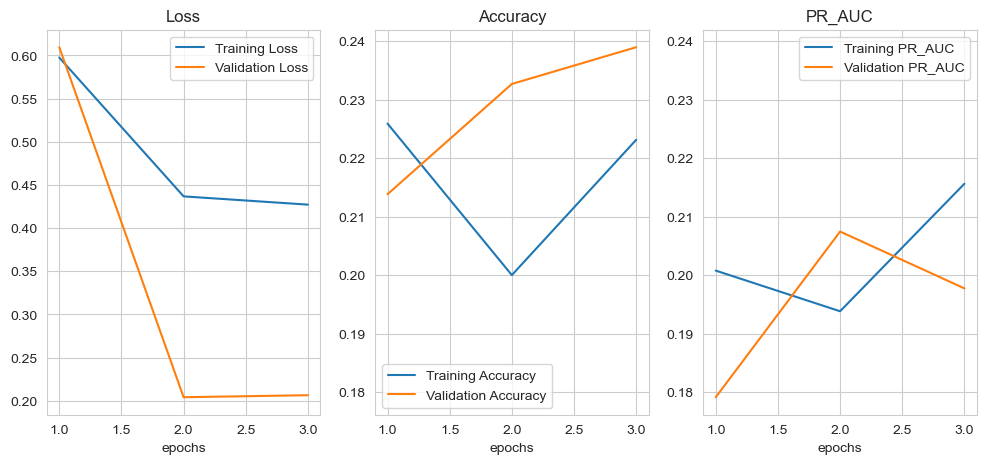

In [722]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

In [602]:
show_predictions(model, visualization=False)

neutral is joyfulness (25.89%)
joyfulness is joyfulness (25.84%)
neutral is joyfulness (30.97%)
disgust is disgust (34.32%)
joyfulness is neutral (25.35%)
disgust is fear (30.97%)
anger is fear (27.86%)
neutral is joyfulness (28.11%)
neutral is joyfulness (30.43%)
neutral is neutral (26.82%)


### Матрица ошибок

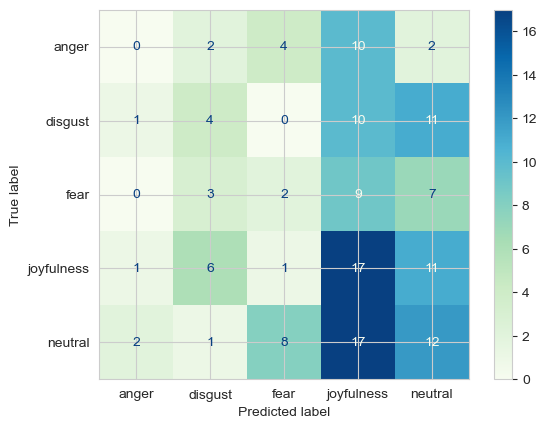

In [603]:
confusion_matrix(model)

### Вывод

In [604]:
val_acc_best = np.max(hist.history['val_accuracy'])
val_auc_best = np.max(hist.history['val_PR_AUC'])
model_best_results = round(val_acc_best, 2), round(val_auc_best, 2)

print(f'val_accuracy: {model_best_results[0]}')
print(f'val_PR_AUC: {model_best_results[1]}')

val_accuracy: 0.31
val_PR_AUC: 0.29


In [724]:
# сохраним данные о модели
model_pretrained = model
hist_pretrained = hist

In [606]:
# stat_3['SGD 1_layer_1024'] = model_best_results[1]

In [607]:
# stat_3

{'1_layer_1024': 0.27, 'SGD 1_layer_1024': 0.29}

## Разморозка слоев

In [746]:
do_fine_tuning = True
# feature_extractor = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
#                                                include_top=False,
#                                                weights='imagenet')
feature_extractor.trainable = do_fine_tuning

print(f'Разморозка слоев: {do_fine_tuning}.')

Разморозка слоев: True.


Посмотрим на количество слоев в предобученной модели:

In [736]:
# с какого слоя мы размораживаем модель
fine_tune_at = 1

# Заморозим все остальные слои
for layer in feature_extractor.layers[:fine_tune_at]:
    layer.trainable = False

In [747]:
print("Number of layers in the feature extractor: ", len(feature_extractor.layers))
print("Trainable layers in the feature extractor: ", len(feature_extractor.trainable_variables))

Number of layers in the feature extractor:  780
Trainable layers in the feature extractor:  488


## Компиляция

Теперь необходимо скомпилировать нашу уже обученную на предыдущем этапе модель, чтобы изменения были применены.

In [748]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss='mse',
              metrics=metrics)

## Архитектура модели

In [749]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_8   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_112 (Dropout)       (None, 1536)              0   

In [750]:
len(model.trainable_variables)

490

## Обучение

In [751]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule])

Epoch 1/500
 3/34 [=>............................] - ETA: 49:09 - loss: 0.4828 - accuracy: 0.1250 - PR_AUC: 0.1769  


KeyboardInterrupt



### Визуализация данных по работе алгоритма

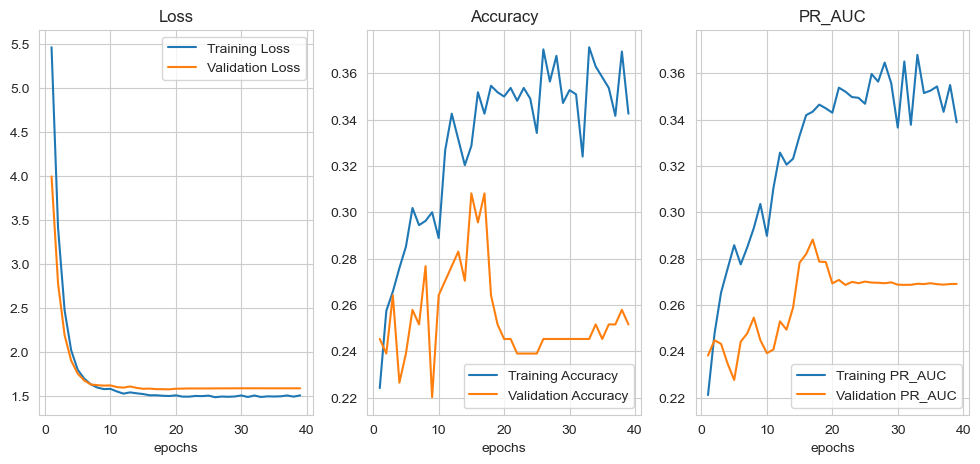

In [601]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

In [602]:
show_predictions(model, visualization=False)

neutral is joyfulness (25.89%)
joyfulness is joyfulness (25.84%)
neutral is joyfulness (30.97%)
disgust is disgust (34.32%)
joyfulness is neutral (25.35%)
disgust is fear (30.97%)
anger is fear (27.86%)
neutral is joyfulness (28.11%)
neutral is joyfulness (30.43%)
neutral is neutral (26.82%)


### Матрица ошибок

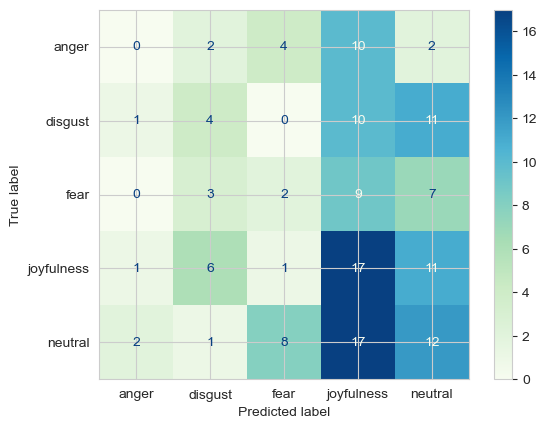

In [603]:
confusion_matrix(model)

### Вывод

In [604]:
val_acc_best = np.max(hist.history['val_accuracy'])
val_auc_best = np.max(hist.history['val_PR_AUC'])
model_best_results = round(val_acc_best, 2), round(val_auc_best, 2)

print(f'val_accuracy: {model_best_results[0]}')
print(f'val_PR_AUC: {model_best_results[1]}')

val_accuracy: 0.31
val_PR_AUC: 0.29


In [605]:
# сохраним данные о модели
model_32 = model
hist_32 = hist

In [606]:
stat_3['SGD 1_layer_1024'] = model_best_results[1]

In [607]:
stat_3

{'1_layer_1024': 0.27, 'SGD 1_layer_1024': 0.29}

# <b>Модель 4</b> | Слои свертки

## Модуль `tf.keras.applications` | `feature_extractor_layer`

Дополним существующую архитектуру слоями свертки и сжатия изображений и посмотрим, насколько изменится результат. Также добавим слои `dropout` и `batchnormalization`.

In [152]:
do_fine_tuning = False
feature_extractor = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet',
                                               # classes=num_classes
                                                     )
feature_extractor.trainable = do_fine_tuning

## Архитектура модели

In [180]:
print(f'Строим модель на базе {MODULE_HANDLE}.')
print(f'Разморозка слоев: {do_fine_tuning}.\n')

model = tf.keras.Sequential([

            rescale,
            data_aug,

            feature_extractor,

            tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=2, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=2, activation='relu'),
            # tf.keras.layers.MaxPooling2D((2, 2)),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(dropout),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(num_classes, activation='softmax')

], name='convnet_model')

model.build(input_shape=(None,) + IMAGE_SIZE + (3,))
model.summary()

Строим модель на базе tf.keras.applications.MobileNetV2.
Разморозка слоев: False.

Model: "convnet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_23 (Conv2D)          (None, 4, 4, 32)          368672    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 2, 2, 32)         0         
 g2D)                                                            
                                    

In [181]:
len(model.trainable_variables)

8

## Компиляция

In [182]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

## Обучение модели

In [183]:
EPOCHS = 15

hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches)

Epoch 1/15
34/34 [==============================] - 71s 2s/step - loss: 1.7079 - accuracy: 0.3296 - val_loss: 2.2441 - val_accuracy: 0.2893
Epoch 2/15
34/34 [==============================] - 58s 2s/step - loss: 1.4723 - accuracy: 0.4176 - val_loss: 1.8625 - val_accuracy: 0.2642
Epoch 3/15
34/34 [==============================] - 60s 2s/step - loss: 1.2983 - accuracy: 0.4935 - val_loss: 1.4661 - val_accuracy: 0.3899
Epoch 4/15
34/34 [==============================] - 57s 2s/step - loss: 1.1978 - accuracy: 0.5231 - val_loss: 1.3851 - val_accuracy: 0.4654
Epoch 5/15
34/34 [==============================] - 60s 2s/step - loss: 1.1289 - accuracy: 0.5565 - val_loss: 1.6501 - val_accuracy: 0.4151
Epoch 6/15
34/34 [==============================] - 57s 2s/step - loss: 1.0881 - accuracy: 0.5769 - val_loss: 1.3348 - val_accuracy: 0.4277
Epoch 7/15
34/34 [==============================] - 70s 2s/step - loss: 1.0678 - accuracy: 0.6083 - val_loss: 1.9261 - val_accuracy: 0.2956
Epoch 8/15
34/34 [==

## Визуализация данных по работе алгоритма

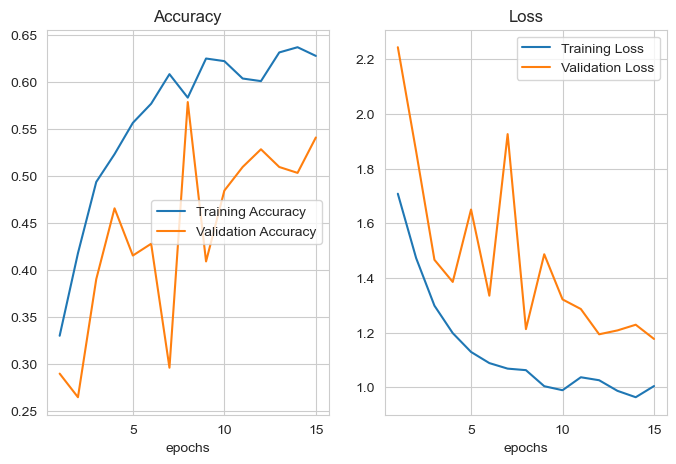

In [184]:
val_acc_viz(hist, EPOCHS)

## Предсказание модели

In [185]:
show_predictions(model)

joyfulness is joyfulness (50.46%)
anger is disgust (28.32%)
disgust is neutral (73.14%)
neutral is neutral (65.20%)
disgust is joyfulness (46.75%)
neutral is neutral (43.82%)
anger is joyfulness (46.27%)
neutral is neutral (62.26%)
neutral is neutral (75.10%)
neutral is neutral (59.74%)


## Матрица ошибок

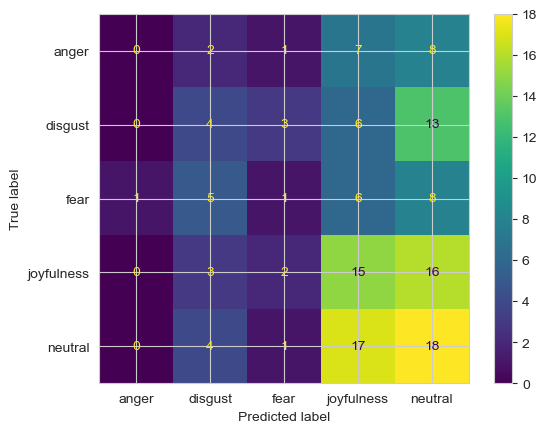

In [186]:
confusion_matrix(model)

## Вывод

Модель по-прежнему отрабатывает плохо - переобучение наступает до 10-й эпохи, предсказательная способность остается даже ниже, чем у второй модели. Продолжаем эксперимент. 

In [187]:
val_acc_best = np.max(hist.history['val_accuracy'])
model_4_best_result = round(val_acc_best, 2)
model_4_best_result

0.58

In [188]:
# сохраним данные о модели
model_4 = model
hist_4 = hist

# <b>Модель 5</b> | Больше слоёв классификатора

## Модуль `tf.keras.applications` | `feature_extractor_layer`

Попробуем пойти вглубь и добавить полносвязных слоев.

In [131]:
do_fine_tuning = False
feature_extractor = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet',
                                               classes=num_classes)
feature_extractor.trainable = do_fine_tuning

## Архитектура модели

In [132]:
print(f'Строим модель на базе {MODULE_HANDLE}.')
print(f'Разморозка слоев: {do_fine_tuning}.\n')

model = tf.keras.Sequential([

            rescale,
            data_aug,

            feature_extractor,

            tf.keras.layers.Conv2D(32, (3, 3), padding="same",
                               strides=1, activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), padding="same",
                               strides=1, activation='relu'),

            tf.keras.layers.Flatten(),

            tf.keras.layers.Dropout(dropout),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(512, activation='relu'),

            tf.keras.layers.Dropout(dropout),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(512, activation='relu'),

            tf.keras.layers.Dropout(dropout),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(num_classes, activation='softmax')

], name='convnet__wider_model')

model.build(input_shape=(None,) + IMAGE_SIZE + (3,))
model.summary()

Строим модель на базе tf.keras.applications.MobileNetV2.
Разморозка слоев: False.

Model: "convnet__wider_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_14 (Conv2D)          (None, 7, 7, 32)          368672    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 3, 3, 32)         0         
 2D)                                                             
                             

In [133]:
len(model.trainable_variables)

16

## Компиляция

In [134]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

## Обучение модели

In [135]:
EPOCHS = 15

hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches)

Epoch 1/15
34/34 [==============================] - 71s 2s/step - loss: 2.1642 - accuracy: 0.2481 - val_loss: 1.8232 - val_accuracy: 0.3459
Epoch 2/15
34/34 [==============================] - 54s 2s/step - loss: 1.9446 - accuracy: 0.2963 - val_loss: 2.3612 - val_accuracy: 0.2516
Epoch 3/15
34/34 [==============================] - 61s 2s/step - loss: 1.7900 - accuracy: 0.3611 - val_loss: 2.0003 - val_accuracy: 0.2956
Epoch 4/15
34/34 [==============================] - 54s 2s/step - loss: 1.6719 - accuracy: 0.3926 - val_loss: 2.0597 - val_accuracy: 0.2956
Epoch 5/15
34/34 [==============================] - 61s 2s/step - loss: 1.5167 - accuracy: 0.4481 - val_loss: 1.5672 - val_accuracy: 0.3899
Epoch 6/15
34/34 [==============================] - 56s 2s/step - loss: 1.4289 - accuracy: 0.4528 - val_loss: 1.6072 - val_accuracy: 0.4151
Epoch 7/15
34/34 [==============================] - 58s 2s/step - loss: 1.3578 - accuracy: 0.4954 - val_loss: 2.0347 - val_accuracy: 0.3145
Epoch 8/15
34/34 [==

## Визуализация данных по работе алгоритма

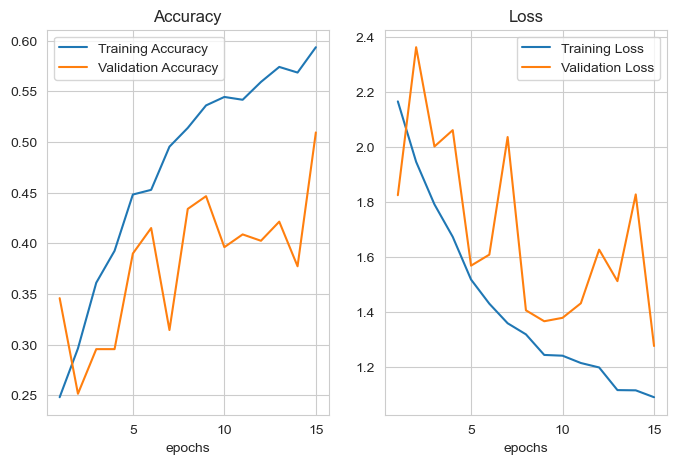

In [136]:
val_acc_viz(hist, EPOCHS)

## Предсказание модели

In [137]:
show_predictions(model)

neutral is neutral (82.95%)
joyfulness is disgust (34.02%)
neutral is neutral (84.58%)
neutral is neutral (80.06%)
neutral is fear (49.44%)
fear is fear (87.75%)
neutral is neutral (62.91%)
disgust is neutral (39.37%)
fear is neutral (53.79%)
disgust is neutral (74.56%)


## Матрица ошибок

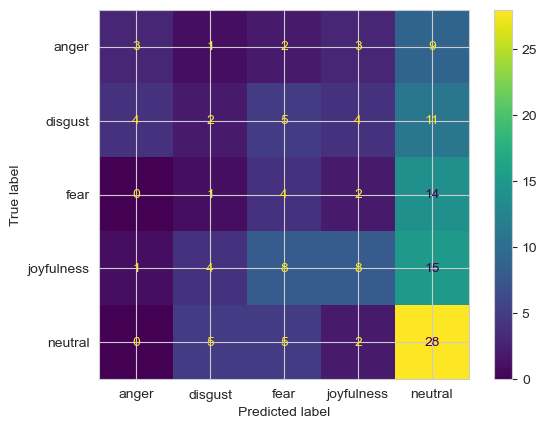

In [138]:
confusion_matrix(model)

## Вывод

Модель по-прежнему отрабатывает плохо - переобучение наступает до 10-й эпохи, предсказательная способность остается даже ниже, чем у второй модели. Продолжаем эксперимент. 

In [139]:
val_acc_best = np.max(hist.history['val_accuracy'])
model_5_best_result = round(val_acc_best, 2)
model_5_best_result

0.51

In [140]:
# сохраним данные о модели
model_5 = model
hist_5 = hist

# <b>Модель 6</b> | `fine_tuning`

## Модуль `tf.keras.applications` | `feature_extractor_layer`

На следующем шаге проверим эту же модель, но разморозим часть слоев предобученной модели. В официальных документах указано, что размораживать слои следует только после того, как мы уже обучили собственный классификатор, в ином случае предобученная модель с установленными в случайном порядке весами для новых слоев при обновлении весов потеряет все, чему она была обучена.

Кроме того, нет необходимости в разморозке "нижних слоев", так как они обнаруживают самые простые и общие закономерности, характерные для любых изображений. Цель применения предобученной модели - использовать более "специализированные" слои для дообучения новой модели на новом датасете, поэтому возьмем сравнительно небольшое число "верхних" слоев.

Особого внимания в случае разморозки `feature_extractor` заслуживают слои bacth normalization (`BN`). Это единственные встроенные слои, веса которых не должны обновляться при градиентном спуске, так как эти веса - движущиеся среднее значение и стандартное отклонение для нормализации текущего батча. Запустив модель в режиме `trainable=False`, мы эти слои заморозили. Когда мы на следующем шаге размораживаем всю модель или ее часть, слои BN продолжают работать в режиме inference (движущиеся mean и std), а не обучения (mean и std текущего батча). Это очень важный момент, так как если мы запустим `feature_extractor` сразу в режиме разморозки без предварительного обучения на замороженных слоях (то есть не заморозим веса BN), слои BN будут давать непредсказуемый результат (подробнее о проблеме [здесь](https://keras.io/getting_started/faq/#whats-the-difference-between-the-training-argument-in-call-and-the-trainable-attribute)).

In [100]:
do_fine_tuning = True
feature_extractor = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
feature_extractor.trainable = do_fine_tuning

print(f'Разморозка слоев: {do_fine_tuning}.')

Разморозка слоев: True.


Посмотрим на количество слоев в предобученной модели:

In [112]:
print("Number of layers in the feature extractor: ", len(feature_extractor.layers))
print("Trainable layers in the feature extractor: ", len(feature_extractor.trainable_variables))

Number of layers in the feature extractor:  154
Trainable layers in the feature extractor:  54


In [108]:
# с какого слоя мы размораживаем модель
fine_tune_at = 100

# Заморозим все остальные слои
for layer in feature_extractor.layers[:fine_tune_at]:
    layer.trainable = False

## Компиляция

Теперь необходимо скомпилировать нашу уже обученную на предыдущем этапе модель, чтобы изменения были применены.

In [109]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

## Архитектура модели

In [110]:
model.summary()

Model: "baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_2 (Flatten)         (None, 62720)             0         
                                                                 
 dropout_3 (Dropout)         (None, 62720)             0         
                                                                 
 dense_3 (Dense)             (None, 5)                 313605    
                                                                 
Total params: 2,571,589
Trainable params: 313,605
Non-trainable params: 2,257,984
_________________________________________________________________


In [120]:
len(model.trainable_variables)

2

Итак, у нашей модели 2 переменные, которые будут обучаться - это переменные с весами и свободными членами.

## Обучение модели

In [ ]:
EPOCHS = 15

hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 )

# <b>Модель 7</b> | Финальная модель

Финальная модель будет состоять из двух частей:
- обучение классификатора на предобученой модели с замороженными слоями,
- дообучение классификатора на размороженных слоях.